# ECVGAN

## 导入库 

In [1]:
import glob
import random
import os
import math
import itertools
import sys

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from PIL import Image
import argparse# Importing Libraries

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.autograd import Variable

from torchvision.models import vgg19

## 导入脚本文件

In [3]:
from ECV_Generator import *
from Feature_extractor import *
from Discriminator import *
from util import *

# Image Dataset

- **batch_size**：指定每个批次的样本数量，这里设置为4，表示每次读取4个图像样本。
- **n_cpu**：指定数据加载过程中使用的CPU数量，这里设置为0，表示仅使用主进程进行数据加载。
- **out_channels**：输出图像的通道数，这里设置为3，表示输出的图像是彩色图像。

In [ ]:
batch_size = 4
n_cpu = 0
out_channels = 3

定义了一个名为**ImageDataset**的数据集类。该类继承自Dataset类，需要实现__init__、__getitem__和__len__方法。

- __init__方法**初始化数据集**，接收两个参数：root表示图像文件所在的根目录，transform表示对图像进行的预处理操作。
- __getitem__方法用于**获取指定索引的数据样本**。首先根据索引获取黑白图像文件路径和对应的彩色图像文件路径。然后，读取黑白图像并进行预处理，包括将黑白图像转换为张量并进行尺寸调整。最后，读取彩色图像并应用预处理操作。返回一个字典，包含黑白图像、原始尺寸的黑白图像和彩色图像。
- __len__方法**返回数据集的样本数量**。

接下来，通过调用*DataLoader类来创建数据加载器。DataLoader接收两个参数：数据集对象和一些加载器的配置参数。

- 数据集对象：使用刚才定义的ImageDataset类创建数据集对象，传入图像文件所在的根目录和预处理操作。
- 配置参数：
    batch_size：指定每个批次的样本数量，使用之前定义的batch_size。
    shuffle：指定是否对数据进行洗牌（随机排序），这里设置为True，表示每个批次的样本顺序是随机的。
    num_workers：指定数据加载过程中使用的CPU数量，使用之前定义的n_cpu。

In [34]:
class ImageDataset(Dataset):
    def __init__(self, root, transform): #, shape):
        #height, width = shape
        self.transform = transform

        self.files = sorted(glob.glob(root + "/*.*"))

    def __getitem__(self, index):
        
        black_path = self.files[index % len(self.files)]
        color_path = black_path.replace('black','color')
        
        img_black = np.asarray(Image.open(black_path))
        if(img_black.ndim==2):
            img_black = np.tile(img_black[:,:,None],3)
        (tens_l_orig, tens_l_rs) = preprocess_img(img_black, HW=(400, 400))
        #img_bw = postprocess_tens(tens_l_orig, torch.cat((0*tens_l_orig,0*tens_l_orig),dim=1))
        #img_black = self.transform(img_black)
        
        
        img_color = Image.open(color_path)
        img_color = self.transform(img_color)

        return {"black": tens_l_rs.squeeze(0), 'orig': tens_l_orig.squeeze(0), "color": img_color}


    def __len__(self):
        return len(self.files)
    
root = '/data/train_black/'

transform = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
dataloader = DataLoader(
    ImageDataset(root, transform),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)

torch.Size([400, 400, 1])


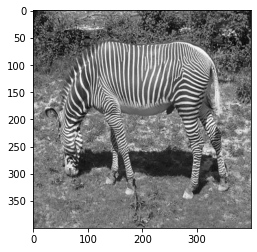

torch.Size([400, 400, 1])


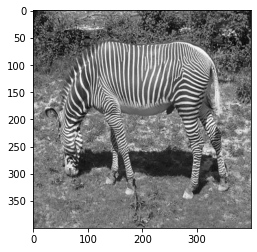

torch.Size([400, 400, 1])


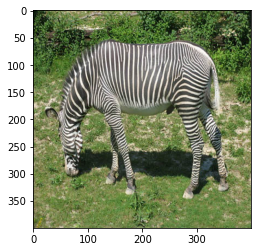

In [35]:
# 从dataloader中获取下一个批次的数据，并可视化其中的图像。
dataiter = iter(dataloader)
data = dataiter.next()

i = 1
img = data['black'][i].permute(1, 2, 0)
print(img.shape)
t = np.zeros((400, 400, 3))
t[..., 0] = img[..., 0]
t = color.lab2rgb(t)
plt.imshow(t)
plt.show()

img = data['orig'][i].permute(1, 2, 0)
print(img.shape)
t = np.zeros((400, 400, 3))
t[..., 0] = img[..., 0]
t = color.lab2rgb(t)
plt.imshow(t)
plt.show()

print(img.shape)
img = data['color'][i].permute(1, 2, 0)
plt.imshow(img)
plt.show()

# Training

In [8]:
os.makedirs("colorit_gan/images", exist_ok=True)
os.makedirs("colorit_gan/saved_models", exist_ok=True)

- **start_epoch**表示训练的起始周期，初始值为0。
- **n_epoch**表示总共的训练周期数，这里设置为50。
- **lr**是学习率，控制模型参数更新的步长，设置为0.0002。
- **b1**和**b2**是Adam优化器的动量参数，分别用于一阶矩估计和二阶矩估计，这里设置为0.5和0.999。
- **decay_epoch**表示学习率衰减的周期数，这里设置为100，表示每经过100个周期，学习率会按照一定的衰减策略进行更新。
- **in_channels**表示输入图像的通道数，这里设置为1，表示灰度图像。
- **out_channels**表示输出图像的通道数，这里设置为3，表示彩色图像。
- **sample_interval**表示每隔多少个批次进行一次样本的生成和保存，用于观察训练过程中生成的图像效果，这里设置为100。
- **checkpoint_interval**表示每隔多少个周期保存一次模型的检查点，用于恢复模型或进行继续训练，这里设置为1。
- **cuda**是一个布尔值，表示是否可用CUDA加速，如果可用，则设置为True，否则设置为False。

In [9]:
start_epoch = 0
n_epochs= 50

lr = 0.0002
b1 = 0.5
b2 = 0.999
decay_epoch = 100
in_channels = 1
out_channels = 3
sample_interval = 100
checkpoint_interval = 1

cuda = torch.cuda.is_available()

In [10]:
shape = (400, 400)

# 初始化生成器（generator）、判别器（discriminator）和特征提取器（feature_extractor），实现在.py文件中
generator = color_ecv(in_channels = 3)
discriminator = Discriminator(input_shape=(out_channels, *shape))
feature_extractor = FeatureExtractor()

# 将特征提取器设置为推断模式
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss() # 生成器和判别器之间的对抗损失函数
criterion_content = torch.nn.L1Loss() # 内容损失函数

# 如果CUDA可用，将生成器、判别器、特征提取器以及损失函数移动到GPU上，以便利用CUDA加速运算
if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

Downloading: "https://colorizers.s3.us-east-2.amazonaws.com/colorization_release_v2-9b330a0b.pth" to /root/.cache/torch/hub/checkpoints/colorization_release_v2-9b330a0b.pth
100.0%
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100.0%


In [18]:
# 用于在开始训练时加载预训练的模型权重
if start_epoch != 0:
    # 加载之前的模型权重
    generator.load_state_dict(torch.load("colorit_gan/saved_models/generator_"+str(start_epoch-1)+".pth"))
    discriminator.load_state_dict(torch.load("colorit_gan/saved_models/discriminator_"+str(start_epoch-1)+".pth"))

In [19]:
# 生成器（generator）和判别器（discriminator）的优化器
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# Training

In [22]:
import warnings
warnings.filterwarnings("ignore")

In [36]:
# ----------
#  Training
# ----------

for epoch in range(start_epoch, n_epochs):
    for i, imgs in enumerate(dataloader):

        # imgs_black : Light Channel of the Image in Model Shape
        # imgs_black_orig : Light Channel of the Image in Original Image Shape
        # imgs_color : Colourfull Image Provided 
        # gen_ab : A and B channel generated by the generator
        # gen_color : Colourfull Image generated by the Generator after postprocessing
        
        
        # 配置模型输入
        # 黑白图像、原始彩色图像的亮度通道和彩色图像转换为PyTorch张量，并将其放置在合适的设备上
        imgs_black = Variable(imgs["black"].type(Tensor))
        imgs_black_orig = Variable(imgs["orig"].type(Tensor))
        imgs_color = Variable(imgs["color"].type(Tensor))

        # 定义对抗损失函数中的真实样本（valid）和生成样本（fake）的标签。
        valid = Variable(Tensor(np.ones((imgs_black.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_black.size(0), *discriminator.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------
        
        # 梯度清零
        optimizer_G.zero_grad()

        # 从低分辨率输入图像生成高分辨率图像
        gen_ab = generator(imgs_black) # 生成器将低分辨率输入图像作为输入，生成对应的 A 和 B 通道图像
        gen_color = postprocess_tens_new(imgs_black_orig, gen_ab) # 将生成的 A 和 B 通道图像与原始输入图像进行后处理，生成彩色图像 gen_color。
        if cuda:
            gen_color = torch.from_numpy(gen_color).to('cuda')

        # 计算对抗性损失（Adversarial loss）
        loss_GAN = criterion_GAN(discriminator(gen_color), valid)

        # Content loss
        """
        - 通过调用特征提取器（feature_extractor）将生成的彩色图像 gen_color 和真实彩色图像 imgs_color 分别提取特征。
        - 使用 .detach() 方法将特征张量从计算图中分离，以便在计算损失时不会对特征提取器产生梯度。
        - 使用内容损失函数（criterion_content）计算生成图像和真实图像之间的内容损失（也称为感知损失）。
        - 生成图像的特征表示为 gen_features，真实图像的特征表示为 real_features。
        - loss_content 表示生成器的内容损失。
        """
        gen_features = feature_extractor(gen_color.detach())
        real_features = feature_extractor(imgs_color.detach())
        loss_content = criterion_content(gen_features, real_features.detach())

        # Total loss
        """
        - 这两部分损失被加权相加，其中对抗损失乘以一个较小的权重因子（1e-3）。
        - 这个权重因子用于平衡内容损失和对抗损失的相对重要性。
        - 调整这个权重因子可以根据具体问题和训练效果进行调优。
        """
        loss_G = loss_content + 1e-3 * loss_GAN

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # 计算真实图像和生成图像的损失
        loss_real = criterion_GAN(discriminator(imgs_color), valid)
        loss_fake = criterion_GAN(discriminator(gen_color.detach()), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------
        print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
      % (epoch, n_epochs, i, len(dataloader), loss_D.item(), loss_G.item()))


        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            # Save image grid with upsampled inputs and SRGAN outputs
            #imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            gen_color = make_grid(gen_color.detach(), nrow=1, normalize=True)
            imgs_black_orig = make_grid(imgs_black_orig, nrow=1, normalize=True)
            img_grid = torch.cat((imgs_black_orig, gen_color), -1)
            save_image(img_grid, "./colorit_gan/images/%d.png" % batches_done, normalize=False)

    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), "./colorit_gan/saved_models/generator_%d.pth" % epoch)
        torch.save(discriminator.state_dict(), "./colorit_gan/saved_models/discriminator_%d.pth" % epoch)

[Epoch 0/50] [Batch 0/1250] [D loss: 0.136274] [G loss: 0.192328]
[Epoch 0/50] [Batch 1/1250] [D loss: 0.150820] [G loss: 0.196009]
[Epoch 0/50] [Batch 2/1250] [D loss: 0.278110] [G loss: 0.226464]
[Epoch 0/50] [Batch 3/1250] [D loss: 0.386441] [G loss: 0.212699]
[Epoch 0/50] [Batch 4/1250] [D loss: 0.314139] [G loss: 0.205507]
[Epoch 0/50] [Batch 5/1250] [D loss: 0.300508] [G loss: 0.225246]
[Epoch 0/50] [Batch 6/1250] [D loss: 0.206700] [G loss: 0.174705]
[Epoch 0/50] [Batch 7/1250] [D loss: 0.232245] [G loss: 0.223513]
[Epoch 0/50] [Batch 8/1250] [D loss: 0.294174] [G loss: 0.223366]
[Epoch 0/50] [Batch 9/1250] [D loss: 0.225688] [G loss: 0.186635]
[Epoch 0/50] [Batch 10/1250] [D loss: 0.190863] [G loss: 0.239271]
[Epoch 0/50] [Batch 11/1250] [D loss: 0.256277] [G loss: 0.240719]
[Epoch 0/50] [Batch 12/1250] [D loss: 0.192406] [G loss: 0.195333]
[Epoch 0/50] [Batch 13/1250] [D loss: 0.154697] [G loss: 0.235432]
[Epoch 0/50] [Batch 14/1250] [D loss: 0.184720] [G loss: 0.214894]
[Epoc

KeyboardInterrupt: 